# <center> Let's play a little Plague Inc. </center>

## <center> https://github.com/DmitrySerg/COVID-19 </center>

<img src="https://i.kym-cdn.com/entries/icons/facebook/000/027/576/thumb-086-plague-inc-1-1200x675.jpg" width=700>

**Dmitry Sergeev**

**Senior Data Scientist @ ŌURA Health, Head of Data Science Programme @ Otus**

**Tg: @dmitryserg**


Data description: This project will use a collection of datasets, describing the current outbreak of coronavirus disease (COVID-19). The data includes: world airport locations, connections and estimated number of flights per month between them (taken from https://www.flightconnections.com/), estimated population on country and city level (http://worldpopulationreview.com/world-cities/), as well as the current outbreak monitoring data, provided by the Johns Hopkins University Center for Systems Science and Engineering (JHU CCSE) on the number of confirmed, recovered, and death cases (https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data).

In [79]:
# conda install --name python3 -c conda-forge cartopy

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from tqdm import tqdm_notebook
from joblib import Parallel, delayed

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# airport_col = ['ID', 'Name', 'City', 'Country','IATA', 'ICAO', 'Lat', 'Long', 'Alt', 
#                'Timezone', 'DST', 'Tz database time zone', 'type', 'source']
# airport_df = pd.read_csv("https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat",
#                         names = airport_col, index_col = 0)
# airport_df.to_csv("airport_df.csv")

# connections_cols = ['Airline', 'Airline ID', 'Source Airport', 'Source Airport ID',
#               'Dest Airport', 'Dest Airport ID', 'Codeshare', 'Stops', 'equipment']
# connections_df = pd.read_csv("https://raw.githubusercontent.com/jpatokal/openflights/master/data/routes.dat",
#                         names = connections_cols)
# connections_df.to_csv("connections_df.csv")

In [4]:
airport_df = pd.read_csv("data/airport_df.csv", index_col=0)
airport_df.head()

,Name,City,Country,IATA,ICAO,Lat,Long,Alt,Timezone,DST,Tz database time zone,type,source
ID,,,,,,,,,,,,,
1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10,U,Pacific/Port_Moresby,airport,OurAirports
2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10,U,Pacific/Port_Moresby,airport,OurAirports
3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10,U,Pacific/Port_Moresby,airport,OurAirports
4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10,U,Pacific/Port_Moresby,airport,OurAirports
5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10,U,Pacific/Port_Moresby,airport,OurAirports


In [5]:
airport_df.drop(['ICAO', 'Alt', 'Timezone', 'DST', 'Tz database time zone', 'type', 'source'], axis=1, inplace=True)
airport_df = airport_df[~airport_df.IATA.isin([r"\N"])]
airport_df.shape

(6072, 6)

In [6]:
connections_df = pd.read_csv("data/connections_df.csv", index_col=0)
connections_df.head()

,Airline,Airline ID,Source Airport,Source Airport ID,Dest Airport,Dest Airport ID,Codeshare,Stops,equipment
0,2B,410,AER,2965,KZN,2990,NaN,0,CR2
1,2B,410,ASF,2966,KZN,2990,NaN,0,CR2
2,2B,410,ASF,2966,MRV,2962,NaN,0,CR2
3,2B,410,CEK,2968,KZN,2990,NaN,0,CR2
4,2B,410,CEK,2968,OVB,4078,NaN,0,CR2


In [7]:
connections_df.shape

(67663, 9)

In [8]:
routes = pd.read_csv("data/routes.csv", index_col=0)
print(routes.shape)
routes.head()

(28330, 3)


,course_code,destination_code,destination_flights
0,AAA,PPT,6
1,AAA,MKP,0
2,AAA,RRR,0
3,AAA,FAC,0
4,AAK,TRW,12


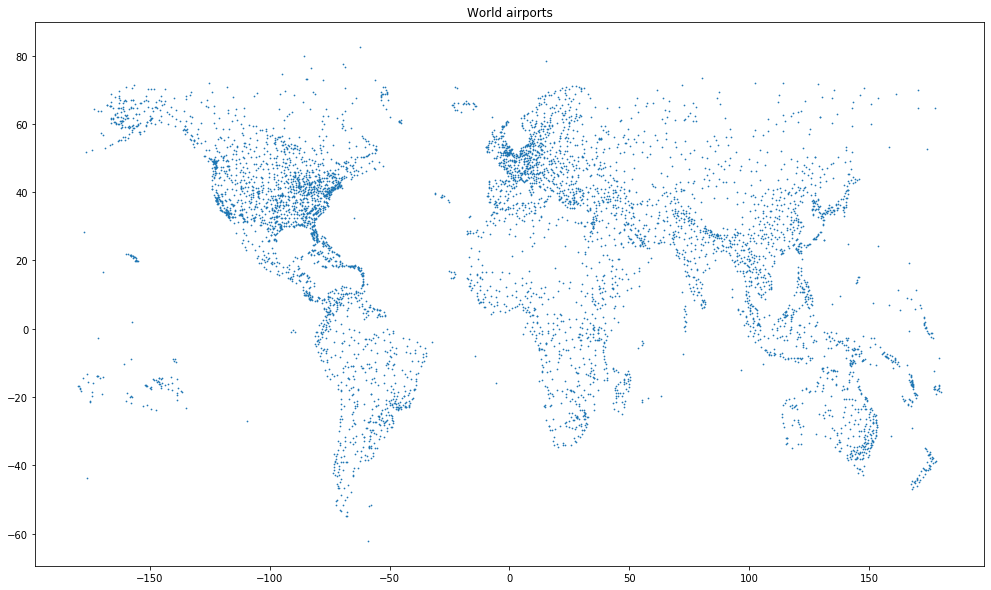

In [9]:
plt.figure(figsize=(17, 10))
plt.title("World airports")
plt.scatter(airport_df.Long, airport_df.Lat, s=0.5)
plt.show()

In [10]:
connections = pd.merge(
    connections_df, 
    routes, 
    how='left', 
    left_on=['Source Airport', 'Dest Airport'], 
    right_on=['course_code', 'destination_code']
)

connections.drop(
    ['course_code', 'destination_code', 'Codeshare', 'Stops', 'equipment'],
    axis=1, inplace=True
)

connections.columns = connections.columns.str.lower().str.split().str.join("_")

## Idea - fill missing number of flights with minimal number of flights from that source

In [11]:
MINIMAL_FLIGHTS_ESTIMATE = 0.1

In [12]:
minimal_flights = connections[
    (connections.destination_flights!=0)&(~connections.destination_flights.isnull())
].groupby(['source_airport']).destination_flights.min()

minimal_flights = np.ceil(minimal_flights*MINIMAL_FLIGHTS_ESTIMATE)

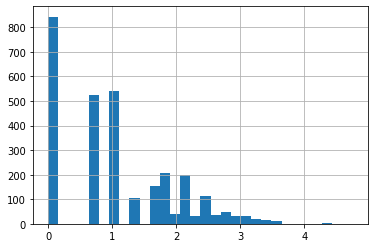

In [13]:
minimal_flights.apply(np.log).hist(bins=30);

In [14]:
connections.destination_flights[
    (connections.destination_flights.isnull())|(connections.destination_flights==0)
] = connections[
    (connections.destination_flights.isnull())|(connections.destination_flights==0)
]['source_airport'].map(minimal_flights)

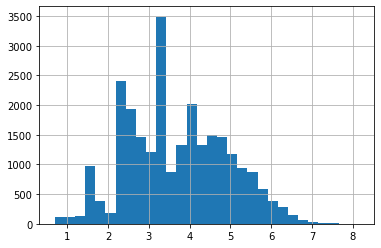

In [15]:
(routes.destination_flights[routes.destination_flights!=0]+1).apply(np.log).hist(bins=30);

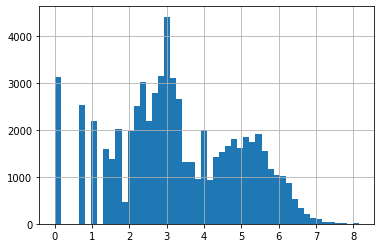

In [16]:
(connections.destination_flights).apply(np.log).hist(bins=50);

In [17]:
connections.head()

,airline,airline_id,source_airport,source_airport_id,dest_airport,dest_airport_id,destination_flights
0,2B,410,AER,2965,KZN,2990,16.0
1,2B,410,ASF,2966,KZN,2990,12.0
2,2B,410,ASF,2966,MRV,2962,8.0
3,2B,410,CEK,2968,KZN,2990,1.0
4,2B,410,CEK,2968,OVB,4078,30.0


In [18]:
connections = pd.merge(
    connections, airport_df[['IATA', 'Lat', 'Long']], left_on='source_airport', right_on='IATA')

connections = pd.merge(
    connections, airport_df[['IATA', 'Lat', 'Long']], left_on='dest_airport', right_on='IATA')

connections.drop(['IATA_x', 'IATA_y'], axis=1, inplace=True)

connections.rename(columns={
    'Lat_x':'lat_source', 
    'Long_x':'long_source',
    'Lat_y':'lat_dest',
    'Long_y':'long_dest'
}, inplace=True)

In [19]:
connections.head()

,airline,airline_id,source_airport,source_airport_id,dest_airport,dest_airport_id,destination_flights,lat_source,long_source,lat_dest,long_dest
0,2B,410,AER,2965,KZN,2990,16.0,43.449902,39.956600,55.606201,49.278702
1,2B,410,ASF,2966,KZN,2990,12.0,46.283298,48.006302,55.606201,49.278702
2,2B,410,CEK,2968,KZN,2990,1.0,55.305801,61.503300,55.606201,49.278702
3,2B,410,DME,4029,KZN,2990,141.0,55.408798,37.906300,55.606201,49.278702
4,S7,4329,DME,4029,KZN,2990,141.0,55.408798,37.906300,55.606201,49.278702


In [20]:
connections.fillna(connections.destination_flights.median(), inplace=True)

In [21]:
# graph = nx.from_pandas_edgelist(connections, source = 'source_airport', target = 'dest_airport',
#                        edge_attr = 'destination_flights', create_using = nx.DiGraph())

# xycoords = {}

# for node in tqdm_notebook(list(graph.nodes), leave=False):
#     xycoords[str(node)] = (
#         airport_df.Long[airport_df.IATA ==node].values[0], 
#         airport_df.Lat[airport_df.IATA == node].values[0]
#     )
    
# plt.figure(figsize=(20, 10))
# nx.draw_networkx_nodes(graph,
#                      pos=xycoords,
#                      with_labels=False,
#                      node_color='k',
#                      node_size=5,
#                      alpha=0.2);

In [22]:
population_country = pd.read_csv("data/country_population.csv", index_col=0)
population_country.pop2019 = population_country.pop2019 * 1000
print(population_country.shape)
population_country.head()

(232, 6)


,name,pop2019,pop2018,GrowthRate,area,Density
Rank,,,,,,
1,China,1.433784e+09,NaN,1.0039,9706961.0,147.7068
2,India,1.366418e+09,NaN,1.0099,3287590.0,415.6290
3,United States,3.290649e+08,NaN,1.0059,9372610.0,35.1092
4,Indonesia,2.706256e+08,NaN,1.0107,1904569.0,142.0928
5,Pakistan,2.165653e+08,NaN,1.0200,881912.0,245.5634


In [23]:
population_city = pd.read_csv("data/city_population.csv", index_col=0)
print(population_city.shape)
population_city.head()

(1723, 5)


,Rank,Name,2020 Population,2019 Population,Change
0,1,Tokyo,37393129,37435191,-0.11%
1,2,Delhi,30290936,29399141,3.03%
2,3,Shanghai,27058479,26317104,2.82%
3,4,Sao Paulo,22043028,21846507,0.90%
4,5,Mexico City,21782378,21671908,0.51%


## Adding city and country population

In [24]:
airport_df = pd.merge(
    airport_df, 
    population_city.rename(
        columns={"Name":"City", "2020 Population":"city_population"}
    )[['City', 'city_population']], 
    how='left', 
    left_on='City', 
    right_on='City'
)

airport_df = pd.merge(
    airport_df, 
    population_country.rename(
        columns={"name":"Country", "pop2019":"country_population", 'Density':'country_density'}
    )[['Country', 'country_population', 'country_density']], 
    how='left', 
    left_on='Country', 
    right_on='Country'
)

In [25]:
population_country

,name,pop2019,pop2018,GrowthRate,area,Density
Rank,,,,,,
1,China,1.433784e+09,NaN,1.0039,9706961.00,147.7068
2,India,1.366418e+09,NaN,1.0099,3287590.00,415.6290
3,United States,3.290649e+08,NaN,1.0059,9372610.00,35.1092
4,Indonesia,2.706256e+08,NaN,1.0107,1904569.00,142.0928
5,Pakistan,2.165653e+08,NaN,1.0200,881912.00,245.5634
...,...,...,...,...,...,...
228,Montserrat,4.989000e+03,NaN,1.0006,102.00,48.9118
229,Falkland Islands,3.377000e+03,NaN,1.0305,12173.00,0.2774
230,Niue,1.615000e+03,NaN,1.0068,260.00,6.2115


In [26]:
airport_df.head()

,Name,City,Country,IATA,Lat,Long,city_population,country_population,country_density
0,Goroka Airport,Goroka,Papua New Guinea,GKA,-6.081690,145.391998,NaN,8776109.0,18.9614
1,Madang Airport,Madang,Papua New Guinea,MAG,-5.207080,145.789001,NaN,8776109.0,18.9614
2,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,-5.826790,144.296005,NaN,8776109.0,18.9614
3,Nadzab Airport,Nadzab,Papua New Guinea,LAE,-6.569803,146.725977,NaN,8776109.0,18.9614
4,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,-9.443380,147.220001,382516.0,8776109.0,18.9614


In [27]:
connections.head()

,airline,airline_id,source_airport,source_airport_id,dest_airport,dest_airport_id,destination_flights,lat_source,long_source,lat_dest,long_dest
0,2B,410,AER,2965,KZN,2990,16.0,43.449902,39.956600,55.606201,49.278702
1,2B,410,ASF,2966,KZN,2990,12.0,46.283298,48.006302,55.606201,49.278702
2,2B,410,CEK,2968,KZN,2990,1.0,55.305801,61.503300,55.606201,49.278702
3,2B,410,DME,4029,KZN,2990,141.0,55.408798,37.906300,55.606201,49.278702
4,S7,4329,DME,4029,KZN,2990,141.0,55.408798,37.906300,55.606201,49.278702


Visualization idea - country population vs country density in plotly

## City population should be proportional to the number of flights from it

In [28]:
airport_df = airport_df[~airport_df.country_population.isnull()]

In [29]:
flights_number = connections.groupby(['source_airport'], as_index=False)[['destination_flights']].sum()
flights_number.head()

,source_airport,destination_flights
0,AAE,198.0
1,AAL,1092.0
2,AAN,16.0
3,AAQ,187.0
4,AAR,224.0


In [30]:
airport_df = pd.merge(airport_df, flights_number, how='left', left_on='IATA', right_on='source_airport')
#airport_df.drop(['source_airport', 'destination_flights'], axis=1, inplace=True)

In [31]:
airport_df = airport_df[~airport_df.source_airport.isnull()]

In [32]:
country_level_flights = np.ceil(
    airport_df[
        airport_df.destination_flights!=0
    ].groupby("Country")['destination_flights'].min() * MINIMAL_FLIGHTS_ESTIMATE
)

In [33]:
airport_df.destination_flights[
    airport_df.destination_flights==0
] = airport_df[
    airport_df.destination_flights==0
]['Country'].map(country_level_flights)

In [34]:
airport_df.isnull().sum()/airport_df.shape[0]

Name                   0.000000
City                   0.000313
Country                0.000000
IATA                   0.000000
Lat                    0.000000
Long                   0.000000
city_population        0.737089
country_population     0.000000
country_density        0.000000
source_airport         0.000000
destination_flights    0.000000
dtype: float64

In [35]:
airport_df[['destination_flights', 'city_population', 'country_population', 'country_density']].corr()

,destination_flights,city_population,country_population,country_density
destination_flights,1.000000,0.511136,0.161578,0.114862
city_population,0.511136,1.000000,0.131050,0.110071
country_population,0.161578,0.131050,1.000000,0.047729
country_density,0.114862,0.110071,0.047729,1.000000


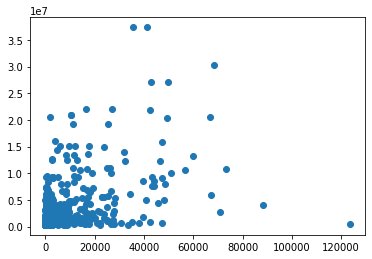

In [36]:
plt.scatter(airport_df.destination_flights, airport_df.city_population)

In [37]:
current_country = airport_df[airport_df.Country=='Russia']

In [38]:
current_country[['city_population', 'destination_flights']][~current_country.city_population.isnull()].sum()

city_population        67901103.0
destination_flights       49674.0
dtype: float64

In [39]:
flights_coefs = airport_df[
    ~airport_df.city_population.isnull()
].groupby("Country")[['city_population', 'destination_flights']].sum()
flights_coefs['coef'] = flights_coefs['city_population']/flights_coefs['destination_flights']

In [40]:
airport_df = airport_df[~airport_df.destination_flights.isnull()]

In [41]:
airport_df['flights_coefficient'] = airport_df.Country.map(flights_coefs.coef)
airport_df['flights_coefficient'].fillna(airport_df['flights_coefficient'].median(), inplace=True)

In [42]:
city_estimates = np.ceil(airport_df.flights_coefficient[airport_df.city_population.isnull()] *\
                 airport_df.destination_flights[airport_df.city_population.isnull()])

airport_df.city_population[airport_df.city_population.isnull()] = city_estimates

In [43]:
connections = connections[connections.source_airport.isin(airport_df.IATA)]
connections = connections[connections.dest_airport.isin(airport_df.IATA)]

From monthly estimates to daily

In [44]:
connections.destination_flights = connections.destination_flights/30

## Network infection spread

--- 


$$P(\text{plane infected}) = \frac{I}{N}$$ 


$$P(\text{new city infected}) = 1 - P(\text{all incoming places are healthy}) = $$

$$= 1- P(\text{all planes from city A are healthy}) \cdot P(\text{all planes from city B are healthy}) \cdot ... \cdot =$$

$$= 1 - [(1 - \frac{I_A}{N_A}) ^ {f_A} \cdot (1 - \frac{I_B}{N_B}) ^ {f_B} \cdot...]$$



$I$ - number of infected in the city, $N$ - total population of the city, $f$ - flights from city per day



In [45]:
def prob_infected_plane(I, N):
    """
    I - number of infected in the city
    N - total population in the city
    """
    return I/N


def prob_city_infected(infectious_sources, populations_sources, daily_flights_sources):
    """
    Calculates the probability that the city will be infected by any of the incoming planes
    
    
    Formula used:
    P(new city infected) = 1 - P(all incoming places are healthy) = \
        = P(all planes from city A are healthy) * P(all planes from city B are healthy) * ...
        = 1 - [(1 - I_A/N_A) ^ f_A * (1 - I_B/N_B) ^ f_B * ...]
        
    """
    prob_all_planes_healthy = 1
    for I, N, f in zip(infectious_sources, populations_sources, daily_flights_sources):    
        prob_all_planes_healthy *= (1-prob_infected_plane(I, N)) ** f
        
    return 1 - prob_all_planes_healthy

In [46]:
prob_city_infected([10, 20], [10000, 20000], [100, 50])

0.1393566173169637

## <center> City infection spread (SIR) </center>

In [47]:
from scipy.integrate import odeint

class SIR:
    def __init__(self, N, I0, beta, gamma, days):
        """
        N - Total population 
        I0 - Initial number of infected individuals, 
        S0 - Everyone else is susceptible to infection initially
        Contact rate, beta, and mean recovery rate, gamma, (in 1/days)
        """
        self.N = N
        self.I0 = I0
        self.beta = beta
        self.gamma = gamma
        self.S0 = N - I0 
        self.days = days

    
    @staticmethod
    def _deriv(y, t, N, beta, gamma):
        """
        The SIR model differential equations
        """
        S, I, R = y
        #print(t)
        dSdt = -beta[int(t)] * S * I / N
        dIdt = beta[int(t)] * S * I / N - gamma * I
        dRdt = gamma * I
        return dSdt, dIdt, dRdt
    
    def run(self):
        # Initial conditions vector
        y0 = self.S0, self.I0, 0
        # Integrating the SIR equations over the time grid, t
        t = list(range(0, self.days))
        # Getting results
        result = odeint(self._deriv, y0, t, args=(self.N, self.beta, self.gamma))
        S, I, R = result.T
        return S, I, R
    
    @staticmethod
    def plot_results(S, I, R):
        fig = plt.figure(facecolor='w')
        ax = fig.add_subplot(111, axisbelow=True)
        ax.plot(S/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
        ax.plot(I/1000, 'r', alpha=0.5, lw=2, label='Infected')
        ax.plot(R/1000, 'g', alpha=0.5, lw=2, label='Recovered')
        ax.set_xlabel('Time /days')
        ax.set_ylabel('Number (1000s)')
        #ax.set_ylim(0,1.2)
        ax.yaxis.set_tick_params(length=0)
        ax.xaxis.set_tick_params(length=0)
        ax.grid(b=True, which='major', c='w', lw=2, ls='-')
        legend = ax.legend()
        legend.get_frame().set_alpha(0.5)
        for spine in ('top', 'right', 'bottom', 'left'):
            ax.spines[spine].set_visible(False)
        plt.show()

In [48]:
from scipy.special import logit, expit

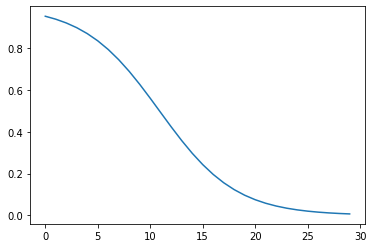

In [49]:
plt.plot(expit(np.linspace(-5, 3, num=30))[::-1])

In [50]:
max_R0 = 5
min_R0 = 1.1

beta = expit(np.linspace(-5, 3, num=60))[::-1]
beta = beta * (max_R0 - min_R0) + min_R0
beta = np.concatenate((beta, np.repeat(beta[-1], 400-len(beta))))

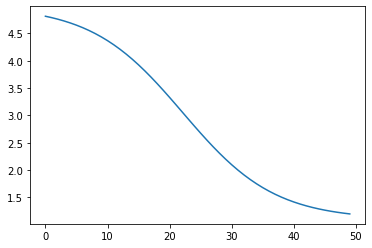

In [51]:
plt.plot(beta[:50])

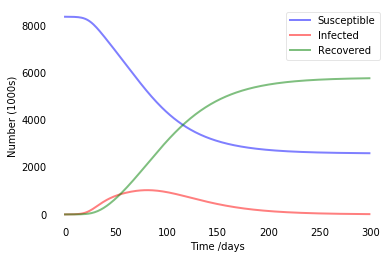

In [52]:
sir_model = SIR(8364977, I0=444, beta=beta/14, gamma=1./20, days=300)
S, I, R = sir_model.run()
sir_model.plot_results(S, I, R)

# Johns Hopkins data

In [53]:
main_link = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'
CONFIRMED = pd.read_csv(main_link+'time_series_covid19_confirmed_global.csv' )
DEATHS = pd.read_csv(main_link+'time_series_covid19_deaths_global.csv')
RECOVERED = pd.read_csv(main_link+'time_series_covid19_recovered_global.csv')

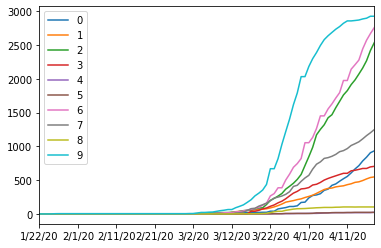

In [54]:
CONFIRMED.iloc[:10, 4:].T.plot()

In [55]:
country = 'China'

confirmed_country = CONFIRMED[CONFIRMED['Country/Region']==country].sum()[4:].values
first_case = np.argwhere(confirmed_country)[0][0]
confirmed_country = confirmed_country[first_case:]

deaths_country = DEATHS[DEATHS['Country/Region']==country].sum()[4:].values[first_case:]
recovered_country = RECOVERED[RECOVERED['Country/Region']==country].sum()[4:].values[first_case:]

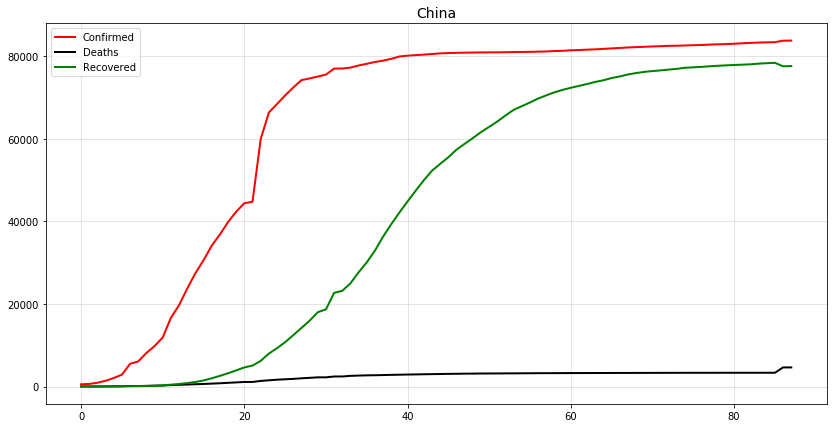

In [56]:
plt.figure(figsize=(14, 7))
plt.title(country, fontsize=14)
plt.plot(
    confirmed_country,
    linewidth=2,
    label='Confirmed',
    color='red'
)
plt.plot(
    deaths_country, 
    linewidth=2,
    label='Deaths',
    color='black'
)
plt.plot(
    recovered_country,
    linewidth=2,
    label='Recovered',
    color='green'
)
plt.legend()
plt.grid(alpha=0.4)
plt.show()

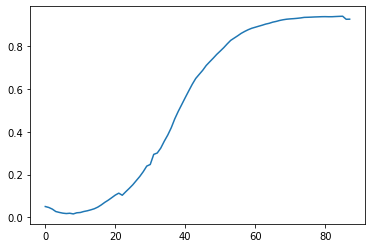

In [57]:
plt.plot(recovered_country/confirmed_country);

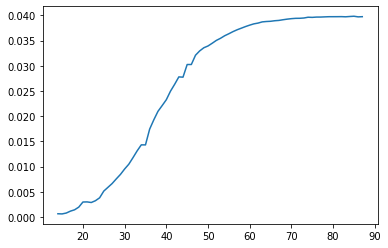

In [58]:
plt.plot(pd.Series(deaths_country).shift(14)/confirmed_country);

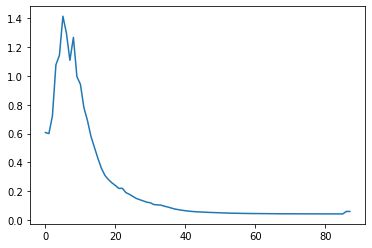

In [59]:
plt.plot(deaths_country/recovered_country);

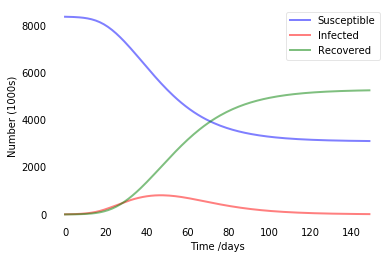

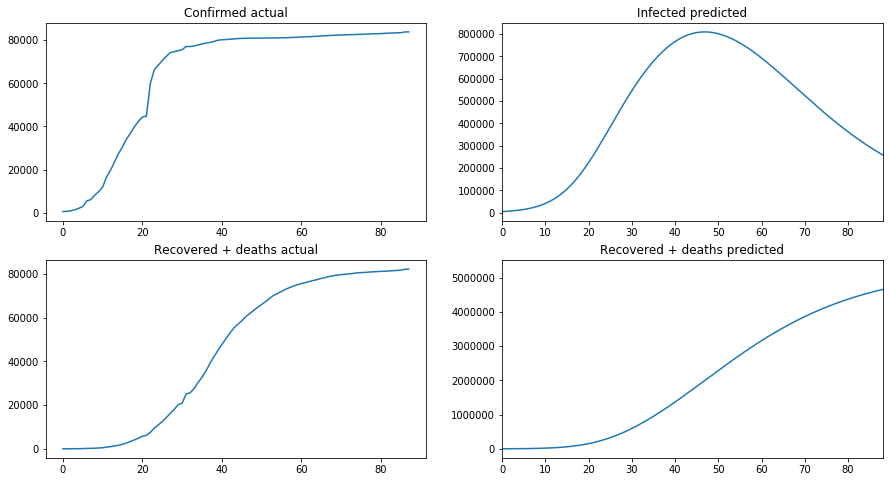

In [60]:
max_R0 = 5
min_R0 = 2.4

beta = expit(np.linspace(-5, 3, num=50))[::-1]
beta = beta * (max_R0 - min_R0) + min_R0
beta = np.concatenate((beta, np.repeat(beta[-1], 400-len(beta))))

sir_model = SIR(8364977, I0=444/0.1, beta=beta/14, gamma=0.0576*2, days=150)
S, I, R = sir_model.run()
sir_model.plot_results(S, I, R)


fig, axs = plt.subplots(2, 2, figsize=(15, 8))
axs[0, 0].plot(confirmed_country)
axs[0, 0].set_title("Confirmed actual")
axs[0, 1].plot(I)
axs[0, 1].set_title("Infected predicted")
axs[0, 1].set_xlim(0, len(confirmed_country))

axs[1, 0].plot(deaths_country+recovered_country)
axs[1, 0].set_title("Recovered + deaths actual")
axs[1, 1].plot(R)
axs[1, 1].set_title("Recovered + deaths predicted")
axs[1, 1].set_xlim(0, len(confirmed_country))
plt.show()

In [61]:
# plt.plot(pd.Series(deaths_country+recovered_country).shift(14)/confirmed_country)
# plt.show()
# plt.plot(pd.Series(R).shift(14)/S)

In [62]:
connections = connections.groupby(["source_airport", 'dest_airport'], as_index=False).agg({
    "destination_flights":np.nansum,
    "lat_source":min,
    "long_source":min,
    "lat_dest":min,
    "long_dest":min
})

In [63]:
connections_graph = nx.from_pandas_edgelist(
    connections, 
    source = 'source_airport', 
    target = 'dest_airport',
    create_using = nx.DiGraph()
)

In [64]:
def calculate_beta(max_R0, min_R0, simulation_days):
    beta = expit(np.linspace(-5, 3, num=60))[::-1]
    beta = beta * (max_R0 - min_R0) + min_R0
    beta = np.concatenate((beta, np.repeat(beta[-1], simulation_days)))
    return beta

SIMULATION_DAYS = 150
BETA = calculate_beta(5, 2.4, SIMULATION_DAYS)
GAMMA = 0.0576*2

In [65]:
def run_sir(city_population, first_infected_number, beta=BETA, gamma=GAMMA, days=SIMULATION_DAYS):
    sir_model = SIR(city_population, I0=first_infected_number, beta=beta/14, gamma=gamma, days=days)
    S, I, R = sir_model.run()
    return S, I, R

In [66]:
INFECTED_CITIES = {}
INFECTED_AIRPORTS = []
NEW_INFECTED = {}

AIRPORT_CODE_TO_CITY = airport_df[['City', 'IATA']].set_index("IATA").to_dict()['City']
CITY_TO_AIRPORT_CODE = airport_df[['City', 'IATA']].groupby("City")['IATA'].unique().to_dict()
CITY_TO_AIRPORT_CODE = {k:list(v) for k, v in CITY_TO_AIRPORT_CODE.items()}
CITY_POPULATION = airport_df[['City', 'city_population']].set_index("City").to_dict()['city_population']

In [67]:
def city_neighbours(city_name, connections_graph=connections_graph):
    city_airports = CITY_TO_AIRPORT_CODE[city_name]
    neighbours = []
    for city in city_airports:
        neighbours.extend(list(connections_graph.neighbors(city)))
    return neighbours

In [68]:
CITY_NEIGHBOURS = {}

for city in airport_df.City.unique():
    try:
        CITY_NEIGHBOURS[city] = city_neighbours(city)
    except:
        continue

In [69]:
NUMBER_OF_FLIGHTS = dict(zip(tuple(
    zip(
        connections.source_airport, 
        connections.dest_airport
    )),
    connections.destination_flights
))

In [70]:
def get_city_neighbours(city_name):
    return CITY_NEIGHBOURS[city_name]

def get_healthy_airports(airports):
    airports = list(set(airports) - set(INFECTED_AIRPORTS))
    return airports

def get_infected_airports(airports):
    airports = list(set(airports).intersection(set(INFECTED_AIRPORTS)))
    return airports

def airports_to_cities(airports):
    return list(set([AIRPORT_CODE_TO_CITY[code] for code in airports]))


# def get_number_of_flights(source, destination, connections_data=connections):
#     if not isinstance(source, list):
#         source = [source]
#     if not isinstance(destination, list):
#         destination = [destination]
        
#     flights = connections_data[
#         connections_data.source_airport.isin(source)&
#         connections_data.dest_airport.isin(destination)
#     ].destination_flights.values.sum()
#     return flights


def get_number_of_flights(source, destination):
    if not isinstance(source, list):
        source = [source]
    if not isinstance(destination, list):
        destination = [destination]
    flights = 0
    for source in source:
        for dest in destination:
            flights+=NUMBER_OF_FLIGHTS[(source, dest)]
    return flights


def get_infected_number(city_name, simulation_day):
    infection_day = INFECTED_CITIES[city_name]['day']
    return INFECTED_CITIES[city_name]['infected'][simulation_day-infection_day]


def calculate_infection_prob(current_susceptible_city, DAY):
    
    current_susceptible_airports = CITY_TO_AIRPORT_CODE[current_susceptible_city]
    current_infected_neighbours = get_infected_airports(get_city_neighbours(current_susceptible_city))

    flights = []
    infected_populations = []
    total_populations = []

    for infected_neighbour in current_infected_neighbours:
        infected_city_name = AIRPORT_CODE_TO_CITY[infected_neighbour]
        flights.append(get_number_of_flights(infected_neighbour, current_susceptible_airports))
        infected_populations.append(get_infected_number(infected_city_name, DAY))
        total_populations.append(CITY_POPULATION[infected_city_name])

    infection_probability = prob_city_infected(infected_populations, total_populations, flights)
    return infection_probability

def run_neighbour_simulation(current_susceptible_city, current_infection_source_city, DAY):
    
    infection_probability = calculate_infection_prob(current_susceptible_city, DAY)

    if np.random.random() < infection_probability:
        S, I, R = run_sir(
            city_population=CITY_POPULATION[current_susceptible_city],
            first_infected_number=100
        )

#         NEW_INFECTED.update({current_susceptible_city:{
#             'day':DAY, 
#             'infected':I,
#             'susceptible':S,
#             'recovered':R,
#             'from': current_infection_source_city
#         }})
        
        return {current_susceptible_city:{
            'day':DAY, 
            'infected':I,
            'susceptible':S,
            'recovered':R,
            'from': current_infection_source_city
        }}
        
        
def run_infectious_city_simulation(current_infection_source_city, DAY):
    neighbour_airports = get_city_neighbours(current_infection_source_city)
    susceptible_airports = get_healthy_airports(neighbour_airports)
    susceptible_cities = airports_to_cities(susceptible_airports)

    results = []
    for current_susceptible_city in tqdm_notebook(
        susceptible_cities, 
        leave=False, 
        desc='susceptible', 
        disable=not VERBOSE
    ):
        
#         if current_susceptible_city not in CHECKED_SUSCEPTIBLE_CITIES:
#             CHECKED_SUSCEPTIBLE_CITIES.append(current_susceptible_city)
        
        try:
            results.append(run_neighbour_simulation(current_susceptible_city, current_infection_source_city, DAY))
        except:
            continue

#     pool = Pool(6)
#     results = list(
#         tqdm_notebook(pool.imap(
#             run_neighbour_simulation, susceptible_cities,
#         ), desc="parallel processing", disable=not VERBOSE, leave=False, total=len(susceptible_cities)))
#     pool.close()
    results = [res for res in results if res]
    return results

In [71]:
from multiprocessing import Pool
from collections import ChainMap

In [72]:
VERBOSE = True

DAY = 0

In [86]:
S, I, R = run_sir(CITY_POPULATION['Wuhan'], 444/0.1)
INFECTED_CITIES = {'Wuhan':{'day':0, 'infected':I, 'susceptible':S, 'recovered':R, 'from':'Wuhan'}}
INFECTED_AIRPORTS = ['WUH']

In [87]:
import pickle

In [88]:
# with open("INFECTED_CITIES", 'wb') as f:
#     pickle.dump(INFECTED_CITIES, f)

In [102]:
for DAY in tqdm_notebook(range(0, 100), desc='Day', leave=False):
    CHECKED_SUSCEPTIBLE_CITIES = []

#     results = Parallel(n_jobs=6, prefer="threads")(
#         delayed(run_infectious_city_simulation)(
#             current_infection_source_city, DAY
#         ) for current_infection_source_city in tqdm_notebook(INFECTED_CITIES.keys(),
#                                                              leave=False, 
#                                                              desc='infection sources',
#                                                              disable=not VERBOSE))
#     results = sum(results, [])
#     NEW_INFECTED.update(dict(ChainMap(*results)))
    
    for current_infection_source_city in tqdm_notebook(
        INFECTED_CITIES.keys(),
        leave=False, 
        desc='infection sources',
        disable=not VERBOSE
        ):

        results = run_infectious_city_simulation(current_infection_source_city, DAY)
        NEW_INFECTED.update(dict(ChainMap(*results)))

    INFECTED_CITIES.update(NEW_INFECTED)
    NEW_INFECTED = {}
    INFECTED_AIRPORTS = sum([CITY_TO_AIRPORT_CODE[city] for city in INFECTED_CITIES.keys()], [])
    #print(pd.DataFrame(INFECTED_CITIES).T['from'].unique())

#     with open("INFECTED_CITIES", 'wb') as f:
#         pickle.dump(INFECTED_CITIES, f)

In [77]:
with open("INFECTED_CITIES", 'rb') as f:
    INFECTED_CITIES = pickle.load(f)

In [90]:
INFECTED_DF = pd.DataFrame(INFECTED_CITIES).T
INFECTED_DF.head()

,day,infected,susceptible,recovered,from
Wuhan,0,"[4440.0, 5604.499991855228, 7065.295906397263,...","[8360537.0, 8358796.534784073, 8356609.1984424...","[0.0, 575.9652240721149, 1302.5056511046628, 2...",Wuhan
Sanya,5,"[100.0, 126.24684555311751, 159.18607388755214...","[625190.0, 625150.7799850556, 625101.473027606...","[0.0, 12.973169391372501, 29.340898506025695, ...",Wuhan
Lijiang,5,"[100.0, 126.2516892963099, 159.20051454257487,...","[1482115.0, 1482075.774897019, 1482026.4572901...","[0.0, 12.973413684611971, 29.342195347098592, ...",Wuhan
Enshi,5,"[100.0, 126.24630632928468, 159.1844619384215,...","[586567.0, 586527.7805520962, 586478.474783398...","[0.0, 12.973141574859548, 29.340754664084717, ...",Wuhan
Kunming,6,"[100.0, 126.25403964042488, 159.2075263159264,...","[4443086.0, 4443046.772427863, 4442997.4496496...","[0.0, 12.973532494532671, 29.342824032370995, ...",Sanya


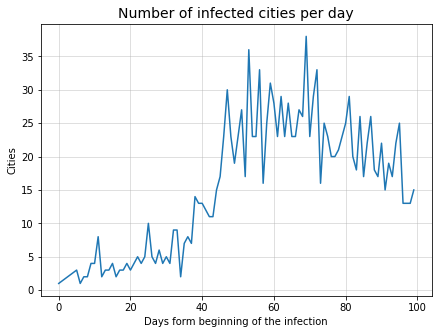

In [101]:
plt.figure(figsize=(7, 5))
plt.plot(INFECTED_DF.groupby('day')['infected'].count())
plt.title("Number of infected cities per day", fontsize=14)
plt.ylabel("Cities")
plt.xlabel("Days form beginning of the infection")
plt.grid(alpha=0.5)
plt.show()

In [92]:
result_cities = INFECTED_DF[['from', 'day']].reset_index()
result_cities.columns = ['destination', 'source', 'day']
result_cities = result_cities[['source', 'destination', 'day']]
result_cities.head()

,source,destination,day
0,Wuhan,Wuhan,0
1,Wuhan,Sanya,5
2,Wuhan,Lijiang,5
3,Wuhan,Enshi,5
4,Sanya,Kunming,6


In [93]:
result_cities = pd.merge(
    result_cities, airport_df[['City', 'Lat', 'Long']], left_on='source', right_on='City')

result_cities = pd.merge(
    result_cities, airport_df[['City', 'Lat', 'Long']], left_on='destination', right_on='City')

result_cities.drop(['City_x', 'City_y'], axis=1, inplace=True)
result_cities.rename(columns={
    'Lat_x':'lat_source', 
    'Long_x':'long_source',
    'Lat_y':'lat_dest',
    'Long_y':'long_dest'
}, inplace=True)

In [94]:
result_cities

,source,destination,day,lat_source,long_source,lat_dest,long_dest
0,Wuhan,Wuhan,0,30.783800,114.208000,30.783800,114.208000
1,Wuhan,Sanya,5,30.783800,114.208000,18.302900,109.412003
2,Wuhan,Lijiang,5,30.783800,114.208000,26.680000,100.246002
3,Wuhan,Enshi,5,30.783800,114.208000,30.320299,109.485001
4,Wuhan,Chongqing,9,30.783800,114.208000,29.719200,106.641998
...,...,...,...,...,...,...,...
1489,Bastia,St-Etienne,99,42.552700,9.483730,45.540600,4.296390
1490,Thunder Bay,Fort Hope,99,48.371899,-89.323898,51.561901,-87.907799
1491,Salvador,Porto Seguro,99,-12.908611,-38.322498,-16.438601,-39.080898
1492,Fortaleza,Sao Luis,99,-3.776280,-38.532600,-2.585360,-44.234100


In [95]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [96]:
graph = nx.from_pandas_edgelist(
    result_cities, 
    source = 'source', 
    target = 'destination',
    create_using = nx.DiGraph()
)

xycoords = {}

for node in tqdm_notebook(list(graph.nodes), leave=False):
    xycoords[str(node)] = (
        airport_df.Long[airport_df.City ==node].values[0], 
        airport_df.Lat[airport_df.City == node].values[0]
    )

In [98]:
from ipywidgets import interactive

def g(x, y):
    graph = nx.from_pandas_edgelist(
        result_cities[result_cities.day<=x], 
        source = 'source', 
        target = 'destination',
        create_using = nx.DiGraph()
    )
    plt.figure(figsize=(30, 15))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()

    ax.add_feature(cfeature.LAND, color='#3d3d3d')
    ax.add_feature(cfeature.OCEAN, color='#04031c')
    #ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    ax.outline_patch.set_visible(False)

    if y=='Nodes':
        nx.draw_networkx_nodes(graph,
                             pos=xycoords,
                             with_labels=False,
                             node_color='r',
                             node_size=5,
                             alpha=1)
    else:
        nx.draw_networkx(graph,
                     arrows=True,
                     pos=xycoords,
                     with_labels=False,
                     node_color='r',
                     edge_color='orange',
                     style='dashed',
                     arrowstyle='->',
                     node_size=10,
                     alpha=0.5)

    plt.xlim(-180, 180)
    plt.ylim(-60, 80) 
    plt.show()
    

interactive_plot = interactive(g, x=list(range(0, 100)), y=['Nodes', 'Nodes and paths'])
interactive_plot

interactive(children=(Dropdown(description='x', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,…

In [ ]:
pd.Series.between()

In [110]:
import warnings
warnings.filterwarnings("ignore")

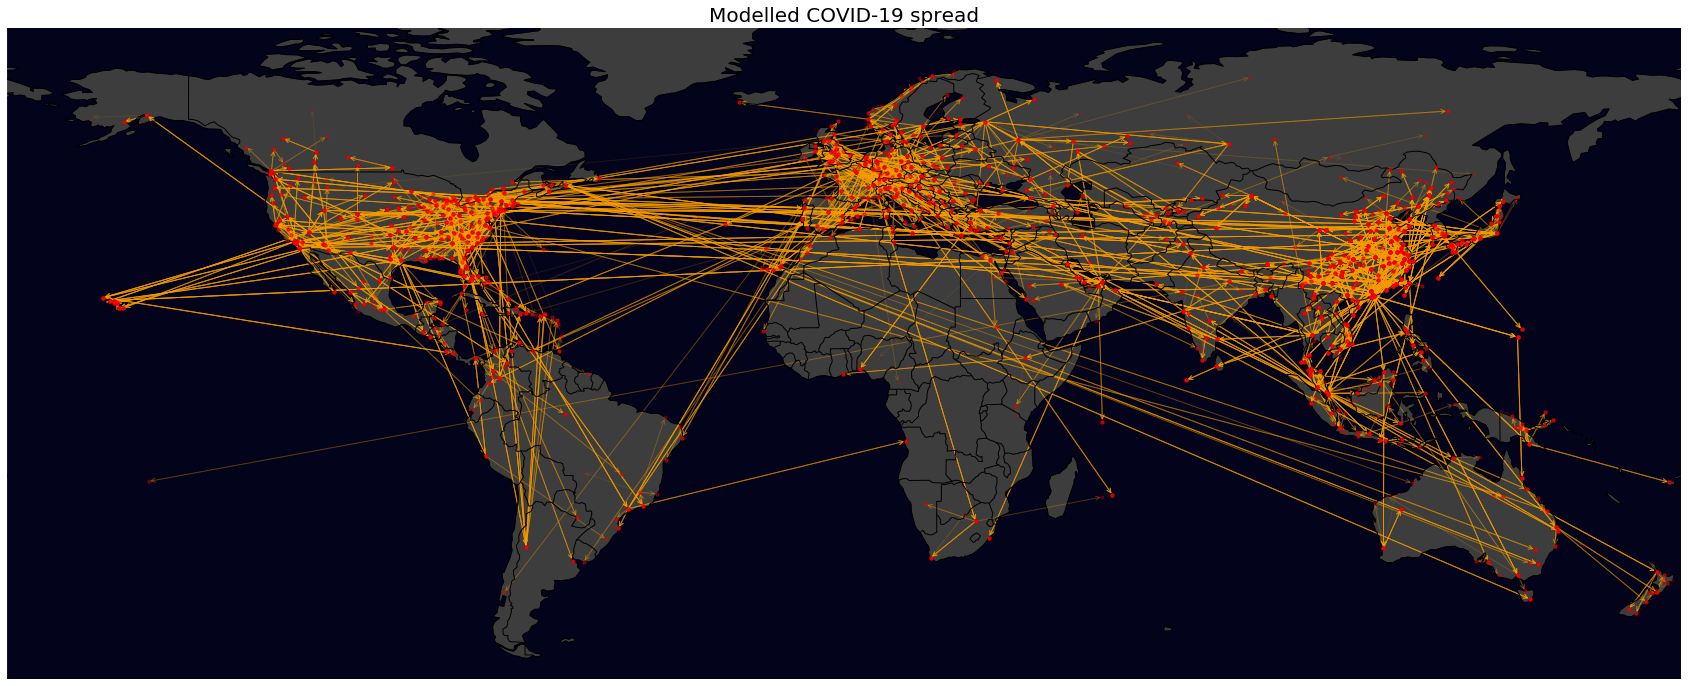

In [139]:
import matplotlib.animation as animation

fig = plt.figure(figsize=(30, 15))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

ax.add_feature(cfeature.LAND, color='#3d3d3d')
ax.add_feature(cfeature.OCEAN, color='#04031c')
#ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.outline_patch.set_visible(False)
plt.xlim(-180, 180)
plt.ylim(-60, 80) 

# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame
ims = []
for x in tqdm_notebook(range(47)):
    
    graph = nx.from_pandas_edgelist(
        result_cities[result_cities.day<=x], 
        source = 'source', 
        target = 'destination',
        create_using = nx.DiGraph()
    )
    
#     im = nx.draw_networkx_nodes(graph,
#                              pos=xycoords,
#                              with_labels=False,
#                              node_color='r',
#                              node_size=5,
#                              alpha=1)
    
    im =nx.draw_networkx(graph,
                     arrows=True,
                     pos=xycoords,
                     with_labels=False,
                     node_color='r',
                     edge_color='orange',
                     style='dashed',
                     arrowstyle='->',
                     node_size=10,
                     alpha=0.1)
    
    ax.set_title(f"Modelled COVID-19 spread", fontsize=20)

    ims.append(ax.get_children())

In [141]:
ani = animation.ArtistAnimation(fig, ims, interval=200, blit=True,
                                repeat_delay=3000)
ani.save("COVID_paths.gif", writer='imagemagick')
plt.show()

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


In [86]:
graph = nx.from_pandas_edgelist(
    connections, 
    source = 'source_airport', 
    target = 'dest_airport',
    edge_attr = 'destination_flights', 
    create_using = nx.DiGraph()
)


xycoords = {}

for node in tqdm_notebook(list(graph.nodes), leave=False):
    xycoords[str(node)] = (
        airport_df.Long[airport_df.IATA ==node].values[0], 
        airport_df.Lat[airport_df.IATA == node].values[0]
    )

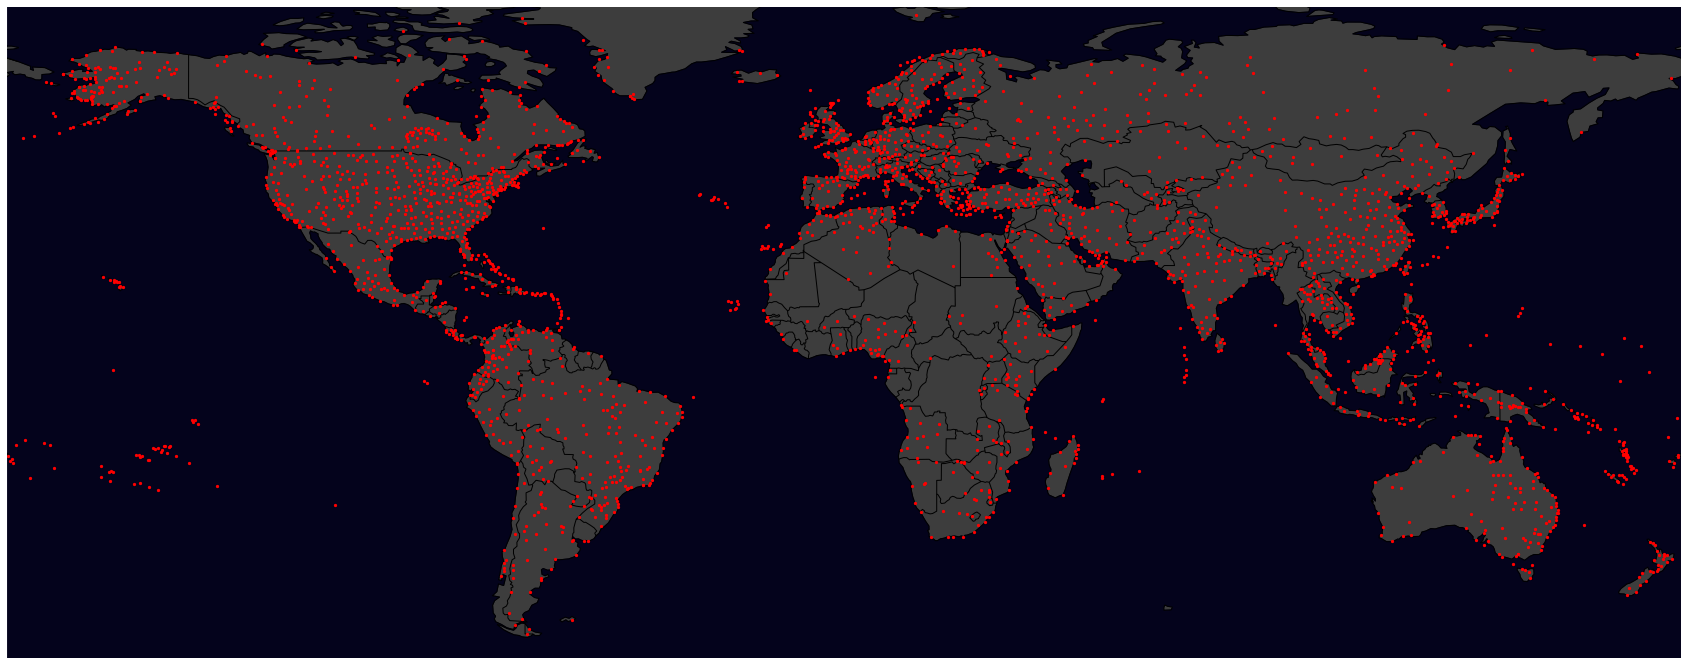

In [87]:
plt.figure(figsize=(30, 15))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

ax.add_feature(cfeature.LAND, color='#3d3d3d')
ax.add_feature(cfeature.OCEAN, color='#04031c')
#ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.outline_patch.set_visible(False)

nx.draw_networkx_nodes(graph,
                     pos=xycoords,
                     with_labels=False,
                     node_color='r',
                     node_size=5,
                     alpha=1)

plt.xlim(-180, 180)
plt.ylim(-60, 80) 
plt.show()

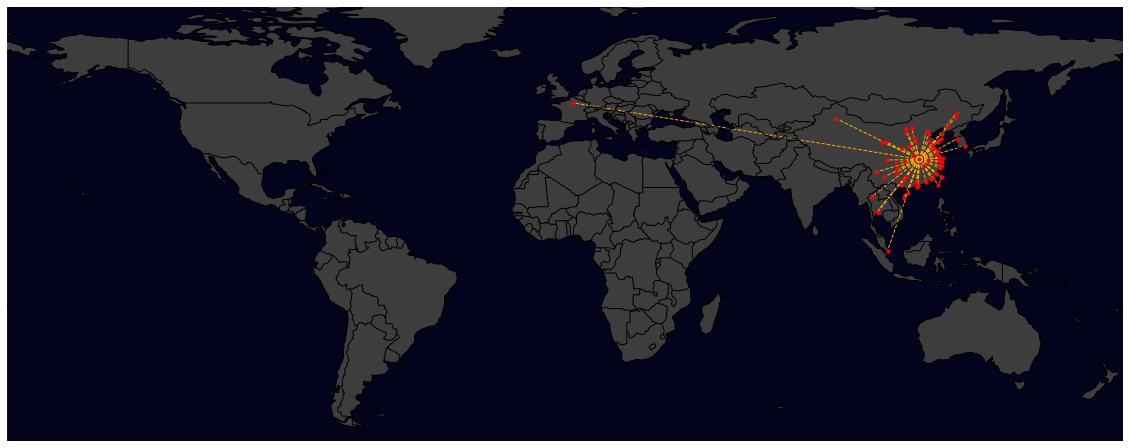

In [88]:
graph = nx.from_pandas_edgelist(
    connections[connections.source_airport=='WUH'], 
    source = 'source_airport', 
    target = 'dest_airport',
    edge_attr = 'destination_flights', 
    create_using = nx.DiGraph()
)

plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

ax.add_feature(cfeature.LAND, color='#3d3d3d')
ax.add_feature(cfeature.OCEAN, color='#04031c')
#ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.outline_patch.set_visible(False)


nx.draw_networkx(graph,
                 arrows=False,
                 pos=xycoords,
                 with_labels=False,
                 node_color='r',
                 edge_color='orange',
                 style='dashed',
                 node_size=10,
                 alpha=1)

plt.xlim(-180, 180)
plt.ylim(-60, 80)
plt.show()

In [153]:
INFECTED_DF[INFECTED_DF.index.isin(airport_df[airport_df.Country=='Finland'].City)]

,day,infected,susceptible,recovered,from
Helsinki,27,"[100.0, 126.2512097962489, 159.19908566129436,...","[1304751.0, 1304711.775400746, 1304662.4588475...","[0.0, 12.973389457331681, 29.342066791610932, ...",London
Turku,36,"[100.0, 126.11745491585415, 158.8005708691101,...","[37803.0, 37763.91591917505, 37714.89315088585...","[0.0, 12.966625909049773, 29.306278244982117, ...",Stockholm
Oulu,39,"[100.0, 126.21473424729761, 159.09029000218763...","[128983.0, 128943.81372031005, 128894.57740781...","[0.0, 12.971545442585981, 29.33230218471348, 4...",Alicante
Vaasa,46,"[100.0, 126.10152765148955, 158.7531857545066,...","[33870.0, 33830.93265228721, 33781.94479537020...","[0.0, 12.96582006133185, 29.302018875320076, 4...",Stockholm


In [472]:
city = 'Moscow'

In [473]:
CITY_POPULATION[city]

12537954.0

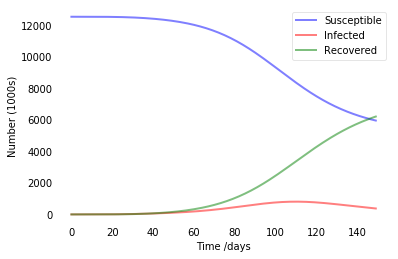

In [474]:
sir_model.plot_results(
    INFECTED_DF[INFECTED_DF.index.isin([city])].susceptible.values[0],
    INFECTED_DF[INFECTED_DF.index.isin([city])].infected.values[0],
    INFECTED_DF[INFECTED_DF.index.isin([city])].recovered.values[0]
)

In [475]:
current_numnber_of_cases = 109
day = np.argwhere(
    INFECTED_DF[INFECTED_DF.index.isin([city])].infected.values[0]/100>=current_numnber_of_cases
)[0][0]

In [476]:
number_of_days_since_first_case = (pd.datetime.now() - pd.to_datetime("2020-02-26")).days

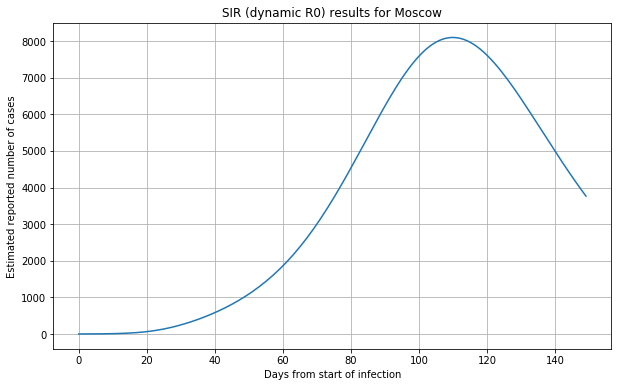

In [477]:
plt.figure(figsize=(10, 6))
plt.plot(INFECTED_DF[INFECTED_DF.index.isin([city])].infected.values[0][:600]/100)
# plt.vlines(
#     number_of_days_since_first_case, 0, 100, label='You are here, enjoy the ride!', color='r', linestyle='--'
# )
plt.title(f"SIR (dynamic R0) results for {city}")
plt.grid()
plt.xlabel("Days from start of infection")
plt.ylabel("Estimated reported number of cases")
#plt.legend()
plt.show()

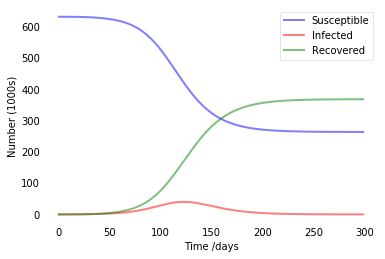

In [471]:
sir_model = SIR(631695, I0=5, beta=beta/14, gamma=0.0576*2, days=300)
S, I, R = sir_model.run()
sir_model.plot_results(S, I, R)

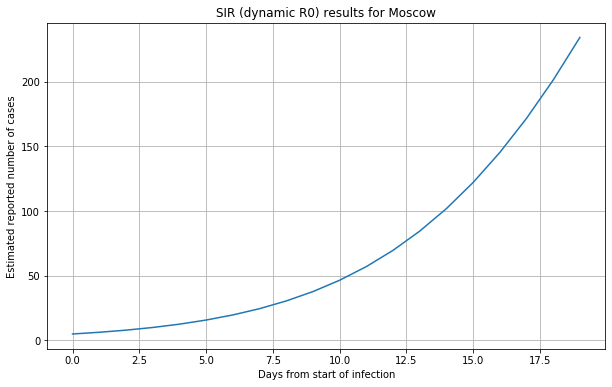

In [449]:
plt.figure(figsize=(10, 6))
plt.plot(I[:20])
# plt.vlines(
#     number_of_days_since_first_case, 0, 3000, label='You are here, enjoy the ride!', color='r', linestyle='--'
# )
plt.title(f"SIR (dynamic R0) results for {city}")
plt.grid()
plt.xlabel("Days from start of infection")
plt.ylabel("Estimated reported number of cases")
#plt.legend()
plt.show()

In [460]:
country = 'Kazakhstan'

country_subset = INFECTED_DF[
    INFECTED_DF.index.isin(airport_df[airport_df.Country==country].City)
]
country_subset

,day,infected,susceptible,recovered,from
Alma-ata,32,"[100.0, 126.25455263734615, 159.2090589962293,...","[7900359.0, 7900319.771888859, 7900270.4479790...","[0.0, 12.97355850225186, 29.34296190985658, 49...",Tbilisi
Tselinograd,36,"[100.0, 126.25449003504713, 159.20886221421267...","[7208137.0, 7208097.771954678, 7208048.4481939...","[0.0, 12.97355528453829, 29.342943845843354, 4...",Urumqi
Aktau,40,"[100.0, 126.25128713204543, 159.19930601695296...","[1330460.0, 1330420.77531951, 1330371.45860754...","[0.0, 12.973393357657887, 29.342086432880574, ...",Baku
Karaganda,46,"[100.0, 126.24486480121197, 159.18014807622706...","[504846.0, 504806.7820663326, 504757.479484933...","[0.0, 12.973068866025985, 29.340366990141312, ...",St. Petersburg


In [461]:
country_subset.day = country_subset.day-country_subset.day.min()

In [462]:
country_infected = pd.DataFrame(country_subset.infected.tolist()).T

In [463]:
for column in country_infected.columns:
    country_infected[column] = country_infected[column].shift(country_subset.day.iloc[column])

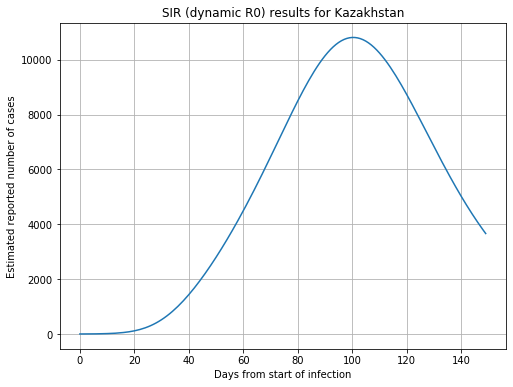

In [464]:
plt.figure(figsize=(8, 6))
plt.plot(country_infected.sum(1)/100)
plt.title(f"SIR (dynamic R0) results for {country}")
plt.grid()
plt.xlabel("Days from start of infection")
plt.ylabel("Estimated reported number of cases")
plt.show()